In [1]:
from collections import defaultdict
from copy import copy
import numpy as np
import operator
import os
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%pylab inline

import logging
logging.basicConfig(level=logging.INFO,
        format='%(levelname)-8s [%(lineno)d] %(message)s')

Populating the interactive namespace from numpy and matplotlib


/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
pylab.rcParams['figure.figsize'] = (20, 10)

In [3]:
matplotlib.rcParams.update({'font.size': 14})
from tikzplotlib import save as tikz_save

In [4]:
tensor_dir = '/mnt/permanent/home/makrai/project/verb-tensor/verb/tensor/0/'

# 1 One-mode similarity

## Data: [SimVerb](http://people.ds.cam.ac.uk/dsg40/simverb.html) (Gerz+ EMNLP 2016)

In [5]:
simverb = pd.read_csv('/mnt/permanent/Language/English/Data/verb-similarity/simverb-3500/SimVerb-3500.txt', sep='\t',
                      header=None, names=['verb1', 'verb2', 'pos', 'sim', 'rel'])

In [6]:
simverb.head()

,verb1,verb2,pos,sim,rel
0,take,remove,V,6.81,SYNONYMS
1,walk,trail,V,4.81,COHYPONYMS
2,feed,starve,V,1.49,ANTONYMS
3,shine,polish,V,7.80,SYNONYMS
4,calculate,add,V,5.98,HYPER/HYPONYMS


In [7]:
simverb.describe(percentiles=[])

,sim
count,3500.000000
mean,4.291554
std,2.652621
min,0.000000
50%,4.320000
max,9.960000


In [8]:
simverb.groupby('rel').sim.describe(percentiles=[]).sort_values('count', ascending=False)

,count,mean,std,min,50%,max
rel,,,,,,
NONE,2093.0,3.431276,2.342695,0.0,3.150,9.79
HYPER/HYPONYMS,800.0,6.012525,2.104537,0.5,6.310,9.96
SYNONYMS,306.0,6.789150,2.104490,0.5,7.140,9.96
COHYPONYMS,190.0,4.435526,2.381992,0.0,4.665,9.30
ANTONYMS,111.0,0.977748,1.074232,0.0,0.660,6.04


## Data: SimLex-999

In [9]:
simlex = pd.read_csv('/mnt/permanent/Language/English/Data/SimLex-999/SimLex-999.txt', sep='\t')

In [10]:
simlex.head()

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93


* conc(w1): The concreteness rating of word1 on a scale of 1-7. Taken from the University of South Florida Free Association Norms database. 

* conc(w2): The concreteness rating of word2 on a scale of 1-7. Taken from the University of South Florida Free Association Norms database. 

* concQ: The quartile the pair occupies based on the two concreteness ratings. Used for some analyses in the above paper. 

* Assoc(USF): The strength of free association from word1 to word2. Values are taken from the University of South Florida Free Association Dataset. 

* SimAssoc333: Binary indicator of whether the pair is one of the 333 most associated in the dataset (according to Assoc(USF)). This subset of SimLex999 is often the hardest for computational models to capture because the noise from high association can confound the similarity rating. See the paper for more details. 

* SD(SimLex): The standard deviation of annotator scores when rating this pair. Low values indicate good agreement between the 15+ annotators on the similarity value SimLex999. Higher scores indicate less certainty. 


In [11]:
simlex.describe(percentiles=[])

,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,4.561572,3.657087,3.568629,2.501502,0.751512,0.333333,1.274505
std,2.614663,1.131050,1.159572,1.118145,1.344569,0.471641,0.366278
min,0.230000,1.190000,1.190000,1.000000,0.000000,0.000000,0.340000
50%,4.670000,3.830000,3.660000,3.000000,0.250000,0.000000,1.310000
max,9.800000,5.000000,5.000000,4.000000,8.850000,1.000000,2.180000


In [12]:
simlex.groupby('POS').size()

POS
A    111
N    666
V    222
dtype: int64

## Testing the verb tensor

In [13]:
consistent_name_d = {'pmi': 'pmi-vanl', 'iact_info': 'iact-vanl', 'log_dice': 'dice-vanl', 
                     'salience': 'pmi-sali', 'iact_sali': 'iact-sali', 'dice_sali': 'dice-sali'}

In [14]:
def test_sim(cutoff=5, max_rank=128, verb=True, normalize=True, lmbda=False):
    for weight in ['log_freq', 'pmi', 'iact_info', 'salience', 'iact_sali', 'log_dice', 'dice_sali']:
        # TODO for weight_oldname, weight_newname in consistent_name_d.items():
        stensor, index = pickle.load(open(
            os.path.join(tensor_dir, 'sparstensr_{}_{}.pkl').format(weight, cutoff),
            mode='rb'))
        logging.info('{} {}'.format(weight, stensor.shape))
        target_df = simverb if verb else simlex
        target_cols = ['verb1', 'verb2'] if verb else ['word1', 'word2']
        relation = 'ROOT' if verb else 'nsubj'
        mode = 1 if verb else 0
        def tensor_based_sim(rank):
            oov = defaultdict(int)
            ktensor, fit, n_iterations, exectimes = pickle.load(open(
                os.path.join(tensor_dir, 'ktensor_{}_{}_{}.pkl').format(weight, cutoff, rank), mode='rb'))
            #modes = ['nsubj', 'ROOT', 'dobj']
            if lmbda:
                sq_lam = np.sqrt(np.apply_along_axis(np.linalg.norm, 0, ktensor.lmbda))
                ktensor.U[mode] *= sq_lam
            if normalize:
                ktensor.U[mode] /= np.apply_along_axis(np.linalg.norm, 1, ktensor.U[mode]).reshape((-1,1))
            def cosine_sim_or_oov(ser):
                try:
                    return ktensor.U[mode][index[relation][ser[0]]] .dot( ktensor.U[mode][index[relation][ser[1]]])
                except KeyError as e:
                    oov[e.args] += 1
                    # TODO Return some kind of median?
                    return 0
            col_name = 'tensor_sim_{}_{}'.format(weight, rank)
            target_df[col_name] = target_df[target_cols].apply(cosine_sim_or_oov, axis=1)
            if rank == max_rank:
                logging.debug(sorted(oov.items(), key=operator.itemgetter(1), reverse=True)[:5])
        for exp in range(int(np.log2(max_rank))+1):
            rank = 2**exp
            try:
                tensor_based_sim(rank=rank)
            except FileNotFoundError as e:
                logging.warning(e)
                target_df['tensor_sim_{}_{}'.format(weight, rank)] = 0
    sim_col = 'sim' if verb else 'SimLex999'
    sim_df = target_df.corr(method='spearman').loc[sim_col][0 if verb else 7 :]
    return sim_df

In [15]:
def df_columns_from_filen(sim_df, verb=True):
    if verb:
        sim_df = sim_df.drop('sim')
    sim_df = sim_df.to_frame().reset_index()
    sim_df [['weight', 'rank_']] = pd.DataFrame(sim_df['index'].str.rsplit('_', 1).values.tolist())
    sim_df.rank_ = sim_df.rank_.astype(int)
    sim_df['weight'] = pd.DataFrame(sim_df['weight'].str.split('_', 2).values.tolist())[2]
    sim_df = sim_df.drop(columns='index')
    sim_df = sim_df.drop(labels=[0])
    sim_df =sim_df[sim_df.isna().sum(axis=1)==0]
    return sim_df.sort_values('sim' if verb else 'SimLex999', ascending=False)

In [28]:
simverb_res = df_columns_from_filen(test_sim())

INFO     [7] log_freq (83681, 16706, 77883)
/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
INFO     [7] pmi (83681, 16706, 77883)
INFO     [7] iact_info (83681, 16706, 77883)
INFO     [7] salience (83681, 16706, 77883)
INFO     [7] iact_sali (83681, 16706, 77883)
INFO     [7] log_dice (83681, 16706, 77883)
INFO     [7] dice_sali (83681, 16706, 77883)


In [17]:
simlex_subj = df_columns_from_filen(test_sim(verb=False), verb=False)

INFO     [7] log_freq (83681, 16706, 77883)
/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
INFO     [7] pmi (83681, 16706, 77883)
INFO     [7] iact_info (83681, 16706, 77883)
INFO     [7] salience (83681, 16706, 77883)
INFO     [7] iact_sali (83681, 16706, 77883)
INFO     [7] log_dice (83681, 16706, 77883)
INFO     [7] dice_sali (83681, 16706, 77883)


In [18]:
simverb_res.sort_values('sim', ascending=False).head()

,sim,weight,rank_
53,0.181016,dice_sali,32
14,0.147285,pmi,64
15,0.140547,pmi,128
52,0.128505,dice_sali,16
6,0.128120,log_freq,64


In [19]:
simlex_subj.sort_values('SimLex999', ascending=False).head()

,SimLex999,weight,rank_
20,0.087048,iact_info,16
31,0.078448,salience,128
35,0.066504,iact_sali,8
7,0.059444,log_freq,128
21,0.047697,iact_info,32


In [29]:
#consistent_name = lambda name: consistent_name_d[name] if name in consistent_name_d else name
simverb_res.weight = simverb_res.weight.apply(consistent_name_d.get)
simlex_subj.weight = simlex_subj.weight.apply(consistent_name_d.get)

In [21]:
weights = pd.unique(simverb_res.weight)

In [22]:
def plot_results(verb=True):
    df0 = simverb_res if verb else simlex_subj
    df0 = df0[df0.rank_ >= 4]
    col = 'sim' if verb else 'SimLex999'
    weights = pd.unique(df0.sort_values(col, ascending=False).weight)
    for weight in weights:
        df = df0[df0.weight==weight].sort_values('rank_')
        plt.plot(df.rank_, df[col])#, c=color)
    plt.xscale('log')
    _ = plt.legend(weights)
    tikz_save('/home/makrai/repo/paper/LREC20/verbtensor/img/{}.tikz'.format('simVerb' if verb else 'simLex-subj'), figurewidth = '\\columnwidth')

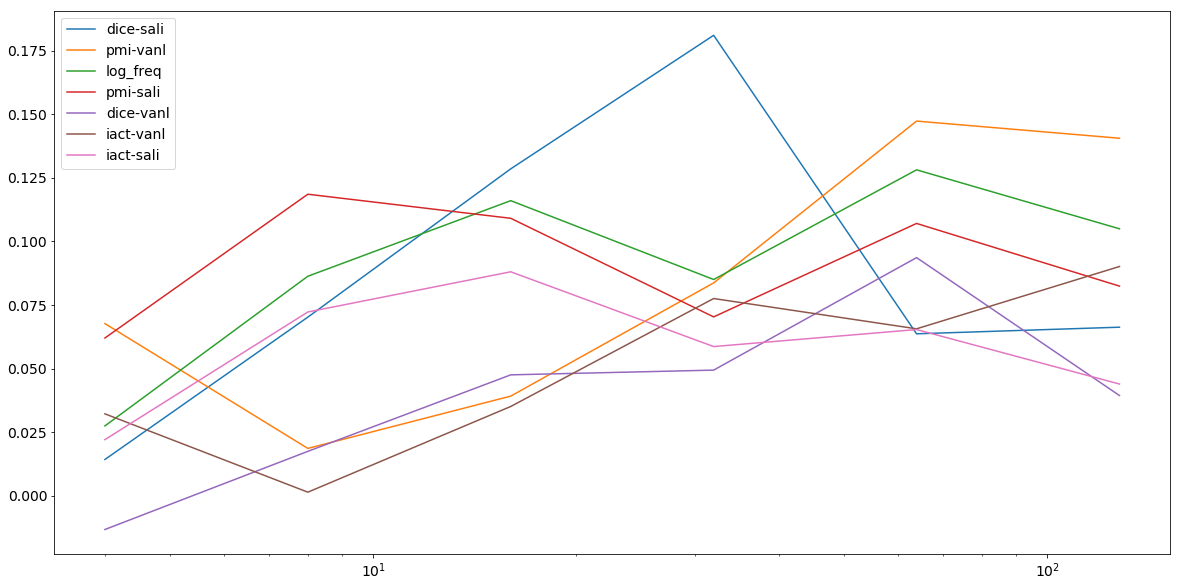

In [23]:
plot_results()

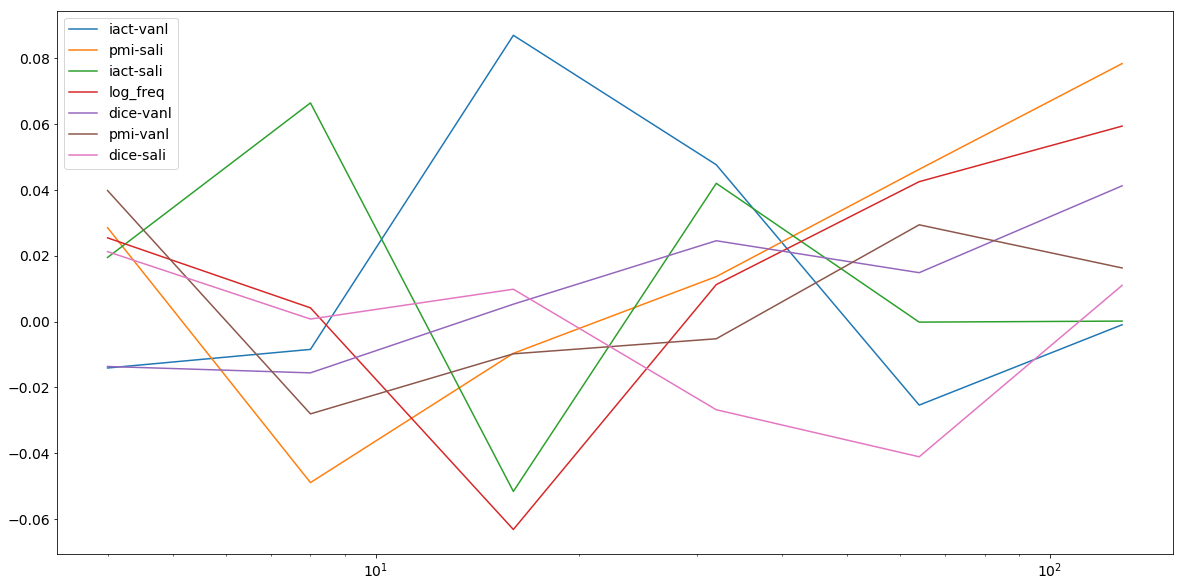

In [24]:
plot_results(verb=False)

# 2 SVO triples (_al et_ Sadrzadeh 2011--2014)

## 2.1 Datasets

  * [GS’11](http://www.cs.ox.ac.uk/activities/compdistmeaning/GS2011data.txt) provided by Grefenstette and Sadrzadeh (EMNLP 2011)
      * each verb pair takes the same subject and object
      * the task has an aspect of a verb sense disambiguation 
          * As discussed in previous work
            (Kartsaklis and Sadrzadeh, 2013; Milajevs+ 2014; Polajnar+ 2014), GS’11
      * For example, the transitive verb “run” is known as polysemous: operate/move
        * “run” and “operate” are similar when subj = “people” and obj = “company”
        * In the same [context, not similar to] “move”
  * ML’10 provided by Mitchell and Lapata (2010),
    * pairs of verb-object phrases and
  * KS’13 provided by Kartsaklis and Sadrzadeh (2013)
    * complements ML’10 by incorporating an appropriate subject for each VO
  * KS’14 provided by [Kartsaklis and Sadrzadeh (2014)](https://arxiv.org/abs/1405.2874)
    * reannotated version of KS’13 using a cloud sourcing service
  * the latter three require one to capture the topical similarity
    rather than the disambiguation aspect (Polajnar+ 2014)

In [19]:
verb_sim_data_dir = '/mnt/permanent/Language/English/Data/verb-similarity/Sadrzadeh/'

In [20]:
def read_sim_data(filen):
    return pd.read_csv(os.path.join(verb_sim_data_dir, filen), sep=' ')

### 2.1.1 Pairs of SVO triples with the same but ambiguous verb (GS11)

In [21]:
gs11 = read_sim_data('GS2011data.txt').groupby(['verb', 'subject', 'object', 'landmark', 'hilo']).mean()
print(gs11.shape)
gs11.head()

(200, 1)


input
verb   subject    object         landmark hilo          
accept government proposal       bear     LOW   2.666667
                                 receive  HIGH  2.583333
                  recommendation bear     LOW   3.500000
                                 receive  HIGH  3.333333
       lawyer     conviction     bear     LOW   3.333333

In [22]:
cols = ['sentence_id', 'adj_subj', 'subj', 'landmark', 'verb', 'adj_obj', 'obj']
gs12 = read_sim_data('GS2012data.txt').groupby(cols).mean().drop(columns=['annotator_id'])
gs12.head()

,,,,,,,annotator_score
sentence_id,adj_subj,subj,landmark,verb,adj_obj,obj,
1,statistical,table,show,express,good,result,6.06
2,statistical,table,show,depict,good,result,5.90
3,recent,study,show,express,significant,correlation,5.72
4,recent,study,show,depict,significant,correlation,5.92
5,annual,figure,show,express,substantial,increase,5.74


In [23]:
cols = ['sentence_id', 'adj_subj', 'subj', 'landmark', 'verb', 'adj_obj', 'obj']
gsk13 = read_sim_data('pickering-judgements.txt').groupby(cols).mean().drop(columns=['annotator_id'])
gsk13.head()

,,,,,,,annotator_score
sentence_id,adj_subj,subj,landmark,verb,adj_obj,obj,
1,private,company,file,register,annual,account,5.441860
2,private,company,file,smooth,annual,account,2.302326
3,young,woman,file,register,long,nail,2.069767
4,young,woman,file,smooth,long,nail,5.023256
5,local,government,file,register,criminal,charge,5.441860


In [24]:
cols = ['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']
ks13_mitchell = read_sim_data('emnlp2013_ml.txt').groupby(cols).mean()
print(ks13_mitchell.shape)
ks13_mitchell.head()

(108, 1)


score
subject1 verb1 object1  subject2 verb2 object2          
agent    sell  property family   buy   home     2.777778
                        group    hold  meeting  1.666667
author   write book     delegate buy   land     1.500000
                        man      hear  word     2.055556
                        writer   read  word     2.777778

### 2.1.1 Kartsaklis and Sadrzadeh, Turk

In [25]:
cols = ['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']
ks13_turk = read_sim_data('emnlp2013_turk.txt').groupby(cols).mean().drop(columns=['annotator'])
ks13_turk.head()

score
subject1 verb1 object1  subject2 verb2 object2          
agent    sell  property family   buy   home     3.125000
                        group    hold  meeting  1.166667
author   write book     delegate buy   land     1.130435
                        man      hear  word     1.640000
                        writer   read  word     3.166667

In [26]:
get_cols = lambda i: ['subject{}'.format(i), 'verb{}'.format(i), 'object{}'.format(i)]
def get_one_sent_from_pair(i):
    df = ks13_mitchell.reset_index()[get_cols(i)]
    df.columns = get_cols('')
    return df
ks13_long = pd.concat(get_one_sent_from_pair(i) for i in [1, 2])
ks13_long = ks13_long.drop_duplicates()

### 2.1.3 [Verb prediction task by Jenatton+ (NIPS 2012)](https://everest.hds.utc.fr/doku.php?id=en:lfmnips12)

In [40]:
dataset_dir = '/mnt/permanent/Language/English/Data/verb-similarity/SVO-tensor-dataset/'
def get_index(pos):
    with open(os.path.join(dataset_dir, 'svo-{}s.lst'.format(pos))) as infile:
        return {i+1: ' '.join(line.strip().split('_')[2:-1]) for i, line in enumerate(infile)}

In [41]:
svo_df = pd.read_csv(os.path.join(dataset_dir, 'svo_data_train_1000000.dat'), sep='\t', header=None, 
                     names=['subject', 'verb', 'object'])

In [42]:
index_verb = get_index('verb')
index_noun = get_index('noun')

In [43]:
svo_df.subject = svo_df.subject.apply(index_noun.get)
svo_df.verb = svo_df.verb.apply(index_verb.get)
svo_df.object = svo_df.object.apply(index_noun.get)

In [44]:
svo_df.head(10)

,subject,verb,object
0,man,swipe,credit card
1,george westinghouse,illuminate,exposition
2,personality,vanish,moment
3,fable,highlight,role
4,secretion,call,surfactant
5,device,store,multimedia
6,diversity,base,engineering
7,troop,destroy,weather station
8,flute,include,vein
9,complication,relate,emphysema


## 2.2 Similarity (KS Turk)

## 2.3 Verb prediction

In [35]:
def predict_verb(weight, rank, cutoff=5, prec_at=1, log_oov=False):
    _, index = pickle.load(open(os.path.join(tensor_dir, 'sparstensr_{}_{}.pkl').format(weight, cutoff), 
                                mode='rb'))
    ktensor, fit, n_iterations, exectimes = pickle.load(open(os.path.join(
        tensor_dir, 'ktensor_{}_{}_{}.pkl').format(weight, cutoff, rank), mode='rb'))
    # modes are ['nsubj', 'ROOT', 'dobj'].
    logging.debug('Making predictions..')
    oov = defaultdict(int)
    def verb_pred(ser):
        i = '' # or '1'
        ser = ser[['subject{}'.format(i), 'object{}'.format(i)]]
        try:
            predicted_ids = np.argsort((
                -ktensor.lmbda * ktensor.U[0][index['nsubj'][ser[0]]]) .dot(
                (ktensor.U[1] * ktensor.U[2][index['dobj'][ser[1]]]).T))
            return [index['ROOT'].inverse[i] for i in predicted_ids[:prec_at]]
        except KeyError as e:
            oov[e.args] += 1
            return []
    svo_sim['predicted_{}_{}'.format(weight, rank)] = svo_sim.apply(verb_pred, axis=1)
    if log_oov:
        logging.debug(sorted(oov.items(), key=operator.itemgetter(1), reverse=True))
    logging.debug('Evaluating predictions..')
    for target in ['landmark', 'verb']:
        def is_good(ser):
            return ser[target] in ser['predicted_{}_{}'.format(weight, rank)]
        svo_sim['good_{}_{}_{}'.format(target, weight, rank)] = svo_sim.apply(is_good, axis=1)
        n_good = svo_sim['good_{}_{}_{}'.format(target, weight, rank)].sum()
        major_baseline = 130 if target == 'landmark' else 260
        if n_good > major_baseline:
            logging.info('{}\t{}\t{}\t{}'.format(target, weight, rank, n_good))

In [36]:
def for_weight_and_rank(max_exp_plus_one=7):
    for weight in ['log_freq', 'pmi', 'iact_info', 'salience', 'iact_sali', 'log_dice', 'dice_sali']:
        logging.info(weight)
        for exp in range(3, max_exp_plus_one):
            rank = 2 ** exp
            logging.info('\t{}'.format(rank))
            try:
                predict_verb(weight, rank)
            except FileNotFoundError as e:
                logging.warning(e)

In [37]:
%time for_weight_and_rank()

INFO     [3] log_freq
INFO     [6] 	8
INFO     [6] 	16
INFO     [6] 	32
INFO     [6] 	64
INFO     [3] pmi
INFO     [6] 	8
INFO     [6] 	16
INFO     [6] 	32
INFO     [6] 	64
INFO     [3] iact_info
INFO     [6] 	8
INFO     [6] 	16


KeyboardInterrupt: 

With 44 k $\times$ 9 k $\times$ 39 k-s tenosor:

|assoc measure|rank|verb|
|-|-|-|
|pmi|256|318|
|salience|128|318|
|log-Dice|128|270|

In [38]:
svo_sim.sum(numeric_only=True).sort_values(ascending=False).head()/svo_sim.shape[0]

input                    3.57266
good_verb_pmi_32         0.12000
good_verb_log_freq_64    0.09000
good_verb_pmi_64         0.09000
good_verb_pmi_8          0.06000
dtype: float64

|verb|`* 1`|`* lmbda`|
|----|--|------|
|unnorm|130|**272**|
|norm|0|24|

Majoroty baseline...

In [39]:
target = 'verb'
svo_sim.groupby(target).size().sort_values()/svo_sim.shape[0]

verb
accept     0.1
buy        0.1
draw       0.1
meet       0.1
provide    0.1
run        0.1
say        0.1
show       0.1
try        0.1
write      0.1
dtype: float64

## Attic: exploring GS11

In [27]:
svo_sim = gs11.reset_index()

In [28]:
svo_sim.hilo = (svo_sim=='HIGH').astype(int)

/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [29]:
cols_ordered = ["subject", "verb", "landmark", "object", "input", "hilo"]

In [30]:
svo_sim[cols_ordered].head()

,subject,verb,landmark,object,input,hilo
0,government,accept,bear,proposal,2.666667,0
1,government,accept,receive,proposal,2.583333,0
2,government,accept,bear,recommendation,3.500000,0
3,government,accept,receive,recommendation,3.333333,0
4,lawyer,accept,bear,conviction,3.333333,0


In [31]:
svo_sim.groupby('landmark').size().sort_values(ascending=False)

landmark
visit       10
test        10
attract     10
bear        10
bribe       10
depict      10
express     10
judge       10
leave       10
move        10
operate     10
picture     10
publish     10
purchase    10
receive     10
satisfy     10
spell       10
state       10
supply      10
allege      10
dtype: int64

In [32]:
svo_sim.groupby('verb').size().sort_values(ascending=False)

verb
write      20
try        20
show       20
say        20
run        20
provide    20
meet       20
draw       20
buy        20
accept     20
dtype: int64

In [33]:
svo_sim.describe(percentiles=[])

,hilo,input
count,200.0,200.000000
mean,0.0,3.572660
std,0.0,1.713468
min,0.0,1.076923
50%,0.0,3.278846
max,0.0,7.000000


In [34]:
svo_sim.corr(method='spearman')

,hilo,input
hilo,NaN,NaN
input,NaN,1.0
